In [1]:
from comet_ml import Experiment
# from comet_ml.integration.pytorch import log_model

from torch.utils.data import DataLoader
import torchvision.datasets
import numpy as np
import torch
import flwr as fl
import argparse
from collections import OrderedDict

from typing import Optional, Dict, List
from flwr.common import Scalar, Config, NDArrays
import warnings
import utils
import datasets
import models
import configs
import copy

warnings.filterwarnings("ignore")

import os
from dotenv import load_dotenv
load_dotenv(os.path.join(os.path.abspath('.'), '.env_comet'))


True

In [2]:
def init_comet_experiment(args: argparse.Namespace):
    experiment = Experiment(
        api_key = os.getenv('COMET_API_TOKEN'),
        project_name = os.getenv('COMET_PROJECT_NAME'),
        workspace= os.getenv('COMET_WORKSPACE'),
    )
    experiment.log_parameters(args)
    experiment.add_tag(args.strategy)
    experiment.add_tag(args.model_name)
    experiment.set_name(f"client_{args.index}_({args.port}_{args.strategy})_lr_{args.learning_rate}_bs_{args.batch_size}_ap_{args.alpha}_ns_{args.noisy}")
    return experiment

In [3]:
import argparse

def init_args(server=True):
    # Parse command line arguments
    parser = argparse.ArgumentParser(description="Start Flower server or client with experiment key.")
    
    # common arguments
    parser.add_argument("--experiment_key", type=str, default="test_key", required=False, help="Experiment key") 
    parser.add_argument("--model_name", type=str, default="vit_tiny_patch16_224", required=False, help="Model to use. Default: vit_tiny_patch16_224")
    parser.add_argument("--use_cuda", action="store_true", default=True, help="Set to true to use cuda. Default: False") 
    parser.add_argument("--port", type=int, default=8080, required=False, help="Port to use for the server. Default: 8080")
    parser.add_argument("--seed", type=int, default=42, required=False, help="seed")
    parser.add_argument("--toy", type=bool, default=False, required=False, help="Set to true to use only 10 datasamples for validation. Useful for testing purposes. Default: False" )
    parser.add_argument("--pretrained", type=bool, default=True, required=False, help="Set to true to use pretrained model. Default: False")
    parser.add_argument("--in_channels", type=int, default=1, required=False, help="Number of input channels. Default: 3")
    parser.add_argument("--class_weights", type=list, default=None, required=False, help="Class weights. Default: None")
    # dataset arguments
    parser.add_argument("--num_clients", type=int, default=10, required=False, help="Number of clients to use. Default: 5")
    parser.add_argument("--dataset", type=str, default="chestxray", required=False, help="Dataset to use. Default: pascal_voc")
    parser.add_argument("--datapath", type=str, default="~/.data/", required=False, help="dataset path")
    parser.add_argument("--alpha", type=float, default=0.1, required=False, help="alpha")
    parser.add_argument("--noisy", type=float, default=0.0, required=False, help="Percentage of noisy data. Default: 0.0")
    # learning arguments
    parser.add_argument("--num_rounds", type=int, default=100, required=False, help="Number of rounds to run. Default: 30")
    parser.add_argument("--local_epochs", type=int, default=2, required=False, help="Number of local epochs. Default: 2")
    parser.add_argument("--learning_rate", type=float, default=0.0001, required=False, help="Learning rate. Default: 0.0001")
    parser.add_argument("--learning_rate_min", type=float, default=0.0001, required=False, help="Learning rate. Default: 0.0001")
    parser.add_argument("--distill_learning_rate", type=float, default=0.0001, required=False, help="Learning rate. Default: 0.0001")
    parser.add_argument("--momentum", type=float, default=0.9, required=False, help="Momentum. Default: 0.9")
    parser.add_argument("--weight_decay", type=float, default=1e-5, required=False, help="Weight decay. Default: 1e-5")
    parser.add_argument("--batch_size", type=int, default=32, required=False, help="Batch size. Default: 32")
    # server arguments
    parser.add_argument("--strategy", type=str, default="fedavg", required=False, help="Strategy to use. Default: fedmhad")
    parser.add_argument("--use_class_weights", type=bool, default=False, required=False, help="Set to true to use class weights. Default: False")
    parser.add_argument("--multifly_lr_lastlayer", type=float, default=100.0, required=False, help="Multiply learning rate of last layer by this factor. Default: 100.0")
    # client arguments
    if not server:
        parser.add_argument("--index", type=int, default=0, required=False, help="Index of the client")
        parser.add_argument("--dry", type=bool, default=False, required=False, help="Set to true to use only 10 datasamples for validation. Useful for testing purposes. Default: False" )

    args = parser.parse_args("")
    if args.dataset == "pascal_voc":
        args.num_classes = 20
        args.task = "multilabel"
    elif args.dataset == "cifar10":
        args.num_classes = 10
        args.task = "singlelabel"
    elif args.dataset == "chestxray":
        args.num_classes = 14
        args.task = "multilabel"
        args.unique_patients = True
    return args  

In [4]:
utils.set_seed(42)
args = init_args(server=False)
experiment = init_comet_experiment(args)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/neighborheo/01-10-growing-dirichlet-x-ray/74faf20bfccc4b769f7cbdf9002dadc7



In [5]:
class CustomClient(fl.client.NumPyClient):
    def __init__(
        self,
        validation_split: int = 0.1,
        experiment: Optional[Experiment] = None,
        args: Optional[argparse.Namespace] = None,
    ):
        self.validation_split = validation_split
        self.experiment = experiment
        self.args = args
        self.save_path = f"checkpoints/{args.port}/client_{args.index}_best_models"
        self.early_stopper = utils.EarlyStopper(patience=10, delta=1e-4, checkpoint_dir=self.save_path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() and self.args.use_cuda else "cpu")
        self.model = models.get_vit_model(self.args.model_name, self.args.num_classes, self.args.pretrained)
        self.trainLoader = None
        self.valLoader = None
        self.testLoader = None
        self.num_examples_train = None
        self.class_counts = None
        
    def __check_n_load_dataset(self):
        if self.trainLoader is None or self.valLoader is None or self.testLoader is None:
            trainset, testset = self.__load_dataset()
            valset_index = np.random.choice(range(len(trainset)), int(len(trainset) * self.validation_split), replace=False)
            valset = torch.utils.data.Subset(trainset, valset_index)
            trainset = torch.utils.data.Subset(trainset, list(set(range(len(trainset))) - set(valset_index)))
            self.trainLoader = DataLoader(trainset, batch_size=self.args.batch_size, shuffle=True)
            self.valLoader = DataLoader(valset, batch_size=self.args.batch_size)
            self.testLoader = DataLoader(testset, batch_size=self.args.batch_size)
            self.num_examples_train = len(trainset)
            self.num_examples_test = len(testset)
            self.class_counts = self.__getClassCounts(trainset, num_classes=self.args.num_classes)
    
    def __load_dataset(self):
        print("Loading dataset...")
        if self.args.dataset == "cifar10":
            cifar10_partition = datasets.Cifar10Partition(self.args)
            trainset, testset = cifar10_partition.load_partition(self.args.index)
        elif self.args.dataset == "chestxray":
            chestxray_partition = datasets.ChestXRayClassificationPartition(self.args)
            self.args.class_weights = chestxray_partition.get_class_weights()
            trainset, testset = chestxray_partition.load_partition(self.args.index)
        else:
            pascal_voc_partition = datasets.PascalVocPartition(self.args)
            trainset, testset = pascal_voc_partition.load_partition(self.args.index)
        if self.args.toy:
            trainset = torch.utils.data.Subset(trainset, range(10))
            testset = torch.utils.data.Subset(testset, range(10))
        print("Dataset loaded.")
        return trainset, testset
    
    def __getClassCounts(self, dataset, num_classes):
        if self.args.task == "multilabel":
            counts = np.sum([dataset[i][1] for i in range(len(dataset))], axis=0)
        else:
            counts = np.bincount([dataset[i][1] for i in range(len(dataset))], minlength=num_classes)
        counts = {str(i): str(counts[i]) for i in range(num_classes)}
        print(f"Class counts : {counts}")
        return counts
    
    def set_parameters(self, parameters):
        """Loads a efficientnet model and replaces it parameters with the ones
        given."""
        model = copy.deepcopy(self.model).to(self.device)
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        # save file 
        model.load_state_dict(state_dict, strict=True)
        return model

    def fit(self, parameters, config):
        """Train parameters on the locally held training set."""
        # Load dataset
        self.__check_n_load_dataset()
        
        # Update local model parameters
        model = self.set_parameters(parameters)

        # Get hyperparameters for this round
        batch_size: int = config["batch_size"]
        epochs: int = config["local_epochs"]
        server_round: int = config["server_round"]
        
        results = utils.train(model, self.trainLoader, self.valLoader, epochs, self.device, self.args)
        
        accuracy = results["val_acc"]
        loss = results["val_loss"]
        is_best_accuracy = self.early_stopper.is_best_accuracy(accuracy)
        if is_best_accuracy:
            filename = f"model_round{server_round}_acc{accuracy:.2f}_loss{loss:.2f}.pth"
            self.early_stopper.save_checkpoint(model, server_round, loss, accuracy, filename)

        if self.early_stopper.counter >= self.early_stopper.patience:
            print(f"Early stopping : {self.early_stopper.counter} >= {self.early_stopper.patience}")
            # todo : stop server
        
        if self.experiment is not None:
            self.experiment.log_metrics(results, step=server_round)
        
        parameters_prime = utils.get_model_params(model)
        
        results.update(self.class_counts)
        return parameters_prime, self.num_examples_train, results

    def evaluate(self, parameters, config):
        """Evaluate parameters on the locally held test set."""
        # Load dataset
        self.__check_n_load_dataset()

        # Update local model parameters
        model = self.set_parameters(parameters)

        # Get config values
        steps: int = config["test_steps"]
        server_round: int = config["server_round"]

        # Evaluate global model parameters on the local test data and return results
        result = utils.test(model, self.testLoader, self.device, self.args)
        accuracy = result["acc"]
        loss = result["loss"]
        result = {f"test_" + k: v for k, v in result.items()}
        
        self.experiment.log_metrics(result, step=server_round)
        return float(loss), self.num_examples_test, {"accuracy": float(accuracy)}


def client_dry_run(experiment: Optional[Experiment] = None
                   , args: Optional[argparse.Namespace] = None) -> None:
    """Weak tests to check whether all client methods are working as
    expected."""
    
    model = models.get_vit_model(args.model_name, args.num_classes, args.pretrained)
    client = CustomClient(validation_split=0.1, experiment= experiment, args= args)
    epoch = 100
    for e in range(epoch):
        parameters_prime, num_examples_train, results = client.fit(
            utils.get_model_params(model),
            {"batch_size": 16, "local_epochs": 3, "server_round": 1},
        )
        model = client.set_parameters(parameters_prime)
        client.evaluate(utils.get_model_params(model), {"test_steps": 32, "server_round": 1})

def test_load_cifar10_partition():
    args = configs.init_args(server=False)
    cifar10_partition = datasets.Cifar10Partition(args)
    trainset, testset = cifar10_partition.load_partition(args.index)
    num_of_data_per_class = cifar10_partition.get_num_of_data_per_class(trainset)
    print(f"Number of data per class: {num_of_data_per_class}")
    return num_of_data_per_class

def main() -> None:
    utils.set_seed(42)
    args = configs.init_args(server=False)
    experiment = init_comet_experiment(args)
    
    if args.dry:
        client_dry_run(experiment, args)
    else:
        # Start Flower client
        client = CustomClient(validation_split=0.1, experiment=experiment, args=args)
        fl.client.start_numpy_client(server_address=f"0.0.0.0:{args.port}", client=client)

    experiment.end()


In [6]:
args = init_args(server=False)
model = models.get_vit_model(args.model_name, args.num_classes, args.pretrained)

In [7]:
import torchxrayvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from sklearn.utils.class_weight import compute_class_weight

In [87]:
class Custom_NIH_Dataset(torchxrayvision.datasets.NIH_Dataset):
    def set_clients_index(self, clients_index, alpha):
        if clients_index is -1:
            return True
        
        self.clients_index = clients_index
        temp_csv = self.csv.copy()
        # in case of fine rows client_id == clients_index 
        temp_csv = temp_csv[temp_csv[f'client_id_{alpha}'] == clients_index]
        self.csv = temp_csv
        return True
    
    def __getitem__(self, index):
        sample = super().__getitem__(index)
        img, lab = sample['img'], sample['lab']
        if img.shape[0] == 1:
            img = np.repeat(img, 3, axis=0)
        return img, lab

In [88]:
args.unique_patients = False
args.alpha = 0.1

In [89]:
args.index=-1

In [90]:
chestxray_partition = datasets.ChestXRayClassificationPartition(args)
args.class_weights = chestxray_partition.get_class_weights()
trainset, testset = chestxray_partition.load_partition(args.index)

num_sample_list:  [4582. 1250. 1217.  221. 5271. 1199. 1126.  154. 7482. 2854. 3342. 1934.
  504. 2726.]
class_weights:  [ 0.3508605   1.2861143   1.3209884   7.274402    0.30499768  1.3408197
  1.4277468  10.4392395   0.21486807  0.56329465  0.48104215  0.83125275
  3.1897676   0.58974427]


Setting XRayResizer engine to cv2 could increase performance.
torch.Size([3, 224, 224])
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


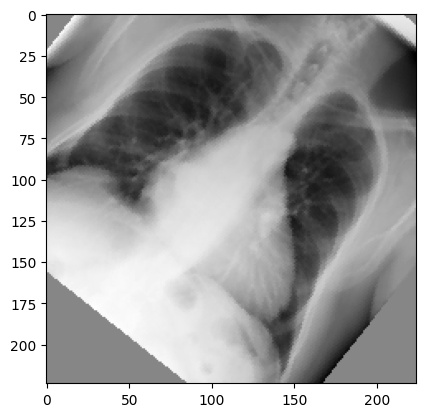

In [91]:
import pathlib
import torchxrayvision

splitdir = pathlib.Path("/home/suncheol/code/FedTest/0_FedMHAD_vit/splitfile/no_unique_patients/")
def custom_transforms(args):
    img = args["img"]
    print(img.shape)
    return img

def custom_transforms_(args):
    img["img"] = args
    return img

transforms = torchvision.transforms.Compose([
    custom_transforms,
    A.Resize(512,512),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    # custom_transforms_,
    A.normalize,
])

data_aug = torchvision.transforms.Compose([
    torchxrayvision.datasets.ToPILImage(),
    torchvision.transforms.RandomAffine(45, 
                                        translate=(0.15, 0.15), 
                                        scale=(0.85, 1.15)),
    torchvision.transforms.ToTensor()
])
transforms = torchvision.transforms.Compose([
    torchxrayvision.datasets.XRayCenterCrop(),
    torchxrayvision.datasets.XRayResizer(224, engine='cv2'),
])

train_dataset = Custom_NIH_Dataset(imgpath="/home/suncheol/.data/NIH_224/images",
                                    csvpath= splitdir / "NIH_dataset_train.csv",
                                    views=["PA"], unique_patients=args.unique_patients,
                                    transform=transforms, data_aug=data_aug)
test_dataset = Custom_NIH_Dataset(imgpath="/home/suncheol/.data/NIH_224/images",
                                    csvpath= splitdir / "NIH_dataset_test.csv",
                                    views=["PA"], unique_patients=args.unique_patients,
                                    transform=transforms)
                    
for img, label in train_dataset:
    print(img.shape)
    print(label)
    break

import matplotlib.pyplot as plt
plt.imshow(img[0], cmap='gray')

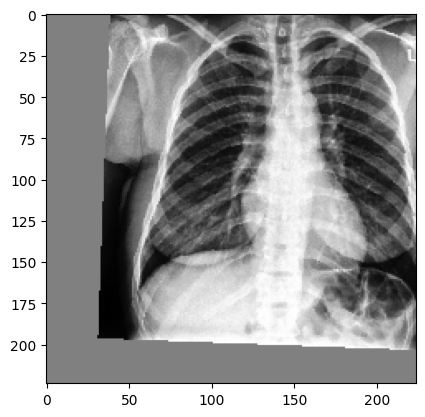

In [112]:
out = dataset[0]
out['img'].shape
plt.imshow(out['img'][0], cmap='gray')

In [109]:
dataset.labels
# where -1, nan to 0    
a = dataset.labels
a[a==-1] = 0
a[np.isnan(a)] = 0
a.sum(axis=1)
# value count of 0 labels
(a.sum(axis=1) == 0).sum()

7118

In [98]:
# -1, Nan = 0
dataset.csv = dataset.csv.fillna(0)
dataset.csv = dataset.csv.replace(-1, 0)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,view,patientid,age_years,sex_male,sex_female
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,PA,00004,20.0,False,True
7,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,PA,00005,33.0,True,False
16,CheXpert-v1.0-small/train/patient00009/study1/...,Male,76,Frontal,PA,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,PA,00009,76.0,True,False
18,CheXpert-v1.0-small/train/patient00010/study1/...,Female,50,Frontal,PA,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,PA,00010,50.0,False,True
20,CheXpert-v1.0-small/train/patient00011/study13...,Female,22,Frontal,PA,NaN,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,PA,00011,22.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188235,CheXpert-v1.0-small/train/patient44899/study3/...,Female,90,Frontal,PA,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,-1.0,NaN,NaN,PA,44899,90.0,False,True
203254,CheXpert-v1.0-small/train/patient51052/study1/...,Male,58,Frontal,PA,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,PA,51052,58.0,True,False
205963,CheXpert-v1.0-small/train/patient52592/study2/...,Female,32,Frontal,PA,NaN,NaN,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,PA,52592,32.0,False,True
214290,CheXpert-v1.0-small/train/patient57768/study2/...,Female,63,Frontal,PA,NaN,NaN,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,NaN,PA,57768,63.0,False,True


In [100]:
dataset.csv = dataset.csv.fillna(0)
dataset.csv = dataset.csv.replace(-1, 0)
dataset.csv

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,view,patientid,age_years,sex_male,sex_female
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,PA,00004,20.0,False,True
7,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,PA,00005,33.0,True,False
16,CheXpert-v1.0-small/train/patient00009/study1/...,Male,76,Frontal,PA,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,PA,00009,76.0,True,False
18,CheXpert-v1.0-small/train/patient00010/study1/...,Female,50,Frontal,PA,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,PA,00010,50.0,False,True
20,CheXpert-v1.0-small/train/patient00011/study13...,Female,22,Frontal,PA,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,PA,00011,22.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188235,CheXpert-v1.0-small/train/patient44899/study3/...,Female,90,Frontal,PA,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,PA,44899,90.0,False,True
203254,CheXpert-v1.0-small/train/patient51052/study1/...,Male,58,Frontal,PA,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,PA,51052,58.0,True,False
205963,CheXpert-v1.0-small/train/patient52592/study2/...,Female,32,Frontal,PA,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,PA,52592,32.0,False,True
214290,CheXpert-v1.0-small/train/patient57768/study2/...,Female,63,Frontal,PA,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,PA,57768,63.0,False,True


In [99]:
len(dataset.labels)

29420

In [113]:
set(dataset.pathologies) | set(train_dataset.pathologies)

{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Enlarged Cardiomediastinum',
 'Fibrosis',
 'Fracture',
 'Hernia',
 'Infiltration',
 'Lung Lesion',
 'Lung Opacity',
 'Mass',
 'Nodule',
 'Pleural Other',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax',
 'Support Devices'}

In [19]:
len(trainset), len(testset)

(1461, 550)

In [20]:
labels = np.array([trainset[i][1] for i in range(len(trainset))])

In [21]:
labels.sum(axis=0)

array([278., 111.,  79.,  15., 313.,  82., 119.,  17., 383., 143., 201.,
       153.,  39., 176.], dtype=float32)

In [22]:
test_labels = np.array([testset[i][1] for i in range(len(testset))])
test_labels.sum(axis=0)

array([ 94.,  60.,  27.,   3., 110.,  27.,  65.,  11., 176.,  43.,  64.,
        49.,  12.,  48.], dtype=float32)

(3, 224, 224)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


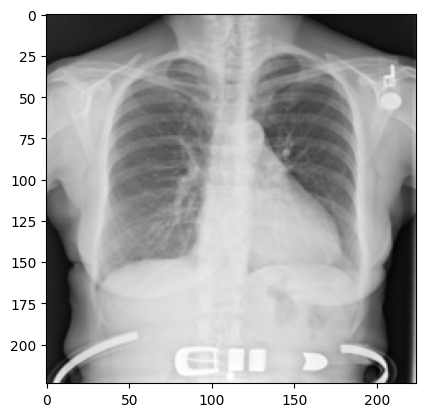

In [14]:
for img, label in trainset:
    print(img.shape)
    print(label)
    break

import matplotlib.pyplot as plt
plt.imshow(img[0], cmap='gray')

In [116]:

class Custom_RSNA_Dataset(torchxrayvision.datasets.RSNA_Pneumonia_Dataset):
    def __getitem__(self, index):
        sample = super().__getitem__(index)
        img, lab = sample['img'], sample['lab']
        if img.shape[0] == 1:
            img = np.repeat(img, 3, axis=0)
        return img, lab

class Custom_CheX_Dataset(torchxrayvision.datasets.CheX_Dataset):
    def __getitem__(self, index):
        sample = super().__getitem__(index)
        img, lab = sample['img'], sample['lab']
        if img.shape[0] == 1:
            img = np.repeat(img, 3, axis=0)
        return img, lab
    
class Custom_NIH_Dataset(torchxrayvision.datasets.NIH_Dataset):
    def set_clients_index(self, clients_index, alpha):
        if clients_index is -1:
            return True
        
        self.clients_index = clients_index
        temp_csv = self.csv.copy()
        # in case of fine rows client_id == clients_index 
        temp_csv = temp_csv[temp_csv[f'client_id_{alpha}'] == clients_index]
        self.csv = temp_csv
        return True
    
    def __getitem__(self, index):
        sample = super().__getitem__(index)
        img, lab = sample['img'], sample['lab']
        if img.shape[0] == 1:
            img = np.repeat(img, 3, axis=0)
        return img, lab

class ChestXRayClassificationPartition:
    def __init__(self, args: argparse.Namespace):
        self.args = args
        self.train_dataset, self.test_dataset = self.get_CheX_dataset(args)
        
    def get_NIH_dataset(self, args):
        if args.unique_patients:
            splitdir = pathlib.Path("/home/suncheol/code/FedTest/0_FedMHAD_vit/splitfile/unique_patients/")
        else:
            splitdir = pathlib.Path("/home/suncheol/code/FedTest/0_FedMHAD_vit/splitfile/no_unique_patients/")
        
        train_dataset = Custom_NIH_Dataset(imgpath="/home/suncheol/.data/NIH_224/images",
                                                csvpath= splitdir / "NIH_dataset_train.csv",
                                                views=["PA"], unique_patients=args.unique_patients,
                                                transform=self.__get_train_transform__(), 
                                                data_aug=self.__get_data_augmentation__())
        test_dataset = Custom_NIH_Dataset(imgpath="/home/suncheol/.data/NIH_224/images",
                                                csvpath= splitdir / "NIH_dataset_test.csv",
                                                views=["PA"], unique_patients=args.unique_patients,
                                                transform=self.__get_train_transform__())
        return train_dataset, test_dataset
    
    def get_CheX_dataset(self, args):
        if args.unique_patients:
            splitdir = pathlib.Path("/home/suncheol/code/FedTest/0_FedMHAD_vit/splitfile/unique_patients/")
        else:
            splitdir = pathlib.Path("/home/suncheol/code/FedTest/0_FedMHAD_vit/splitfile/no_unique_patients/")
        
        datadir= pathlib.Path("/home/suncheol/.data/")
        splitdir = pathlib.Path("/home/suncheol/.data/CheXpert-v1.0-small/")
        train_dataset = Custom_CheX_Dataset(imgpath= datadir / "CheXpert-v1.0-small",
                                            csvpath= datadir / "CheXpert-v1.0-small" / "train.csv",
                                            views=["PA"], unique_patients=args.unique_patients,
                                            transform=self.__get_train_transform__(), 
                                            data_aug=self.__get_data_augmentation__())
        test_dataset = Custom_CheX_Dataset(imgpath= datadir / "CheXpert-v1.0-small",
                                            csvpath= datadir / "CheXpert-v1.0-small" / "valid.csv",
                                            views=["PA"], unique_patients=args.unique_patients,
                                            transform=self.__get_train_transform__())
        return train_dataset, test_dataset
        
    def __get_x_ray_data__(self, dataset_str, masks=False, unique_patients=False,
            transform=None, data_aug=None, merge=True, views = ["PA","AP"],
            pathologies=None):
        
        dataset_dir = "/home/suncheol/.data/"      
        datasets = []
        
        if "rsna" in dataset_str:
            dataset = torchxrayvision.datasets.RSNA_Pneumonia_Dataset(
                imgpath=dataset_dir + "/kaggle-pneumonia-jpg/stage_2_train_images_jpg",
                transform=transform, data_aug=data_aug,
                unique_patients=unique_patients, pathology_masks=masks,
                views=views)
            datasets.append(dataset)

        if "nih" in dataset_str:
            dataset = Custom_NIH_Dataset(
                imgpath=dataset_dir + "NIH_224/images", 
                transform=transform, data_aug=data_aug,
                unique_patients=unique_patients, pathology_masks=masks,
                views=views)
            datasets.append(dataset)
            
        if "chex" in dataset_str:
            dataset = torchxrayvision.datasets.CheX_Dataset(
                imgpath=dataset_dir + "/CheXpert-v1.0-small",
                csvpath=dataset_dir + "/CheXpert-v1.0-small/train.csv",
                transform=transform, data_aug=data_aug, 
                unique_patients=False,
                views=views)
            datasets.append(dataset)
            
        if not pathologies is None:
            for d in datasets:
                torchxrayvision.datasets.relabel_dataset(pathologies, d)
        
        if merge:
            newlabels = set()
            for d in datasets:
                newlabels = newlabels.union(d.pathologies)

            print(list(newlabels))
            for d in datasets:
                torchxrayvision.datasets.relabel_dataset(list(newlabels), d)
                
            dmerge = torchxrayvision.datasets.Merge_Dataset(datasets)
            return dmerge
            
        else:
            return datasets

    def __get_train_transform__(self):
        transforms = torchvision.transforms.Compose([
            torchxrayvision.datasets.XRayCenterCrop(),
            torchxrayvision.datasets.XRayResizer(224, engine='cv2'),
        ])
        return None
        return transforms
    
    def __get_data_augmentation__(self):
        data_aug = torchvision.transforms.Compose([
            torchxrayvision.datasets.ToPILImage(),
            torchvision.transforms.RandomAffine(45, 
                                                translate=(0.15, 0.15), 
                                                scale=(0.85, 1.15)),
            torchvision.transforms.ToTensor()
        ])
        return None
        return data_aug
    
    def load_partition(self, partition=-1):
        if partition >= 0:
            csv = self.train_dataset.csv
            indices = csv[csv[f'client_id_{self.args.alpha}'] == partition].index
            train_dataset = torch.utils.data.Subset(self.train_dataset, indices)
            n_test = int(len(self.test_dataset) / self.args.num_clients)
            test_dataset = torch.utils.data.Subset(self.test_dataset, range(partition * n_test, (partition + 1) * n_test))
        else:
            train_dataset = self.train_dataset
            test_dataset = self.test_dataset
            
        # print(len(train_dataset), len(test_dataset))
        return train_dataset, test_dataset
    
    def get_class_weights(self):
        labels = self.train_dataset.labels
        print(labels.sum(axis=0))
        class_weights = len(labels) / (len(labels[0]) * labels.sum(axis=0))
        print(class_weights)
        return torch.FloatTensor(class_weights)

    def load_public_dataset(self):
        public_dataset = Custom_RSNA_Dataset(imgpath="/home/suncheol/.data/rsna/stage_2_train_images",
                                    views=["PA"])
        return public_dataset

In [115]:
args

Namespace(alpha=0.1, batch_size=32, class_weights=tensor([ 0.3509,  1.2861,  1.3210,  7.2744,  0.3050,  1.3408,  1.4277, 10.4392,
         0.2149,  0.5633,  0.4810,  0.8313,  3.1898,  0.5897]), datapath='~/.data/', dataset='chestxray', distill_learning_rate=0.0001, dry=False, experiment_key='test_key', in_channels=1, index=-1, learning_rate=0.0001, learning_rate_min=0.0001, local_epochs=2, model_name='vit_tiny_patch16_224', momentum=0.9, multifly_lr_lastlayer=100.0, noisy=0.0, num_classes=14, num_clients=10, num_rounds=100, port=8080, pretrained=True, seed=42, strategy='fedavg', task='multilabel', toy=False, unique_patients=False, use_class_weights=False, use_cuda=True, weight_decay=1e-05)

In [117]:
args.index = -1
chestxray_partition = datasets.ChestXRayClassificationPartition(args)
args.class_weights = chestxray_partition.get_class_weights()
trainset, testset = chestxray_partition.load_partition(args.index)

num_sample_list:  [4582. 1250. 1217.  221. 5271. 1199. 1126.  154. 7482. 2854. 3342. 1934.
  504. 2726.]
class_weights:  [ 0.3508605   1.2861143   1.3209884   7.274402    0.30499768  1.3408197
  1.4277468  10.4392395   0.21486807  0.56329465  0.48104215  0.83125275
  3.1897676   0.58974427]


In [118]:
len(trainset), len(testset)

(22507, 5501)